# Heart Attack prediction using Logistic Regression

**Data description**

- Dataset shows chance of heart attack
- 0 = low
- 1 = high

**packages**

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np

%matplotlib inline

## Preparation

**Import and set up data**

In [2]:
# get data
data = pd.read_csv("heart.csv")

# set aside validation data
df_val = data.sample(n=50, random_state=200)

# substract validation data from full data
df=data.drop(df_val.index)

# reset indexes to make working with dataframes easier
df_val.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.values[:,:-1]
Y = df.values[:,-1]

X_val = df_val.values[:,:-1]
Y_val = df_val.values[:,-1]

## data exploration

In [3]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       253 non-null    int64  
 1   sex       253 non-null    int64  
 2   cp        253 non-null    int64  
 3   trtbps    253 non-null    int64  
 4   chol      253 non-null    int64  
 5   fbs       253 non-null    int64  
 6   restecg   253 non-null    int64  
 7   thalachh  253 non-null    int64  
 8   exng      253 non-null    int64  
 9   oldpeak   253 non-null    float64
 10  slp       253 non-null    int64  
 11  caa       253 non-null    int64  
 12  thall     253 non-null    int64  
 13  output    253 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 27.8 KB


In [5]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,253.000000,253.000000,253.00000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,54.367589,0.664032,0.98419,131.063241,246.727273,0.130435,0.529644,148.881423,0.308300,1.073913,1.399209,0.735178,2.312253,0.557312
std,9.205074,0.473264,1.02728,17.448904,52.231786,0.337449,0.530901,22.796063,0.462707,1.189284,0.606446,1.041323,0.598716,0.497689
min,29.000000,0.000000,0.00000,94.000000,131.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.00000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.00000,130.000000,240.000000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.00000,140.000000,274.000000,0.000000,1.000000,165.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.00000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


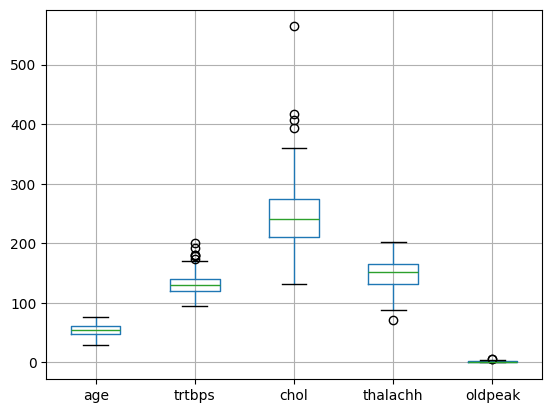

In [6]:
df.boxplot(column = ["age", "trtbps", "chol", "thalachh", "oldpeak"]);

- some outliers exist, not many

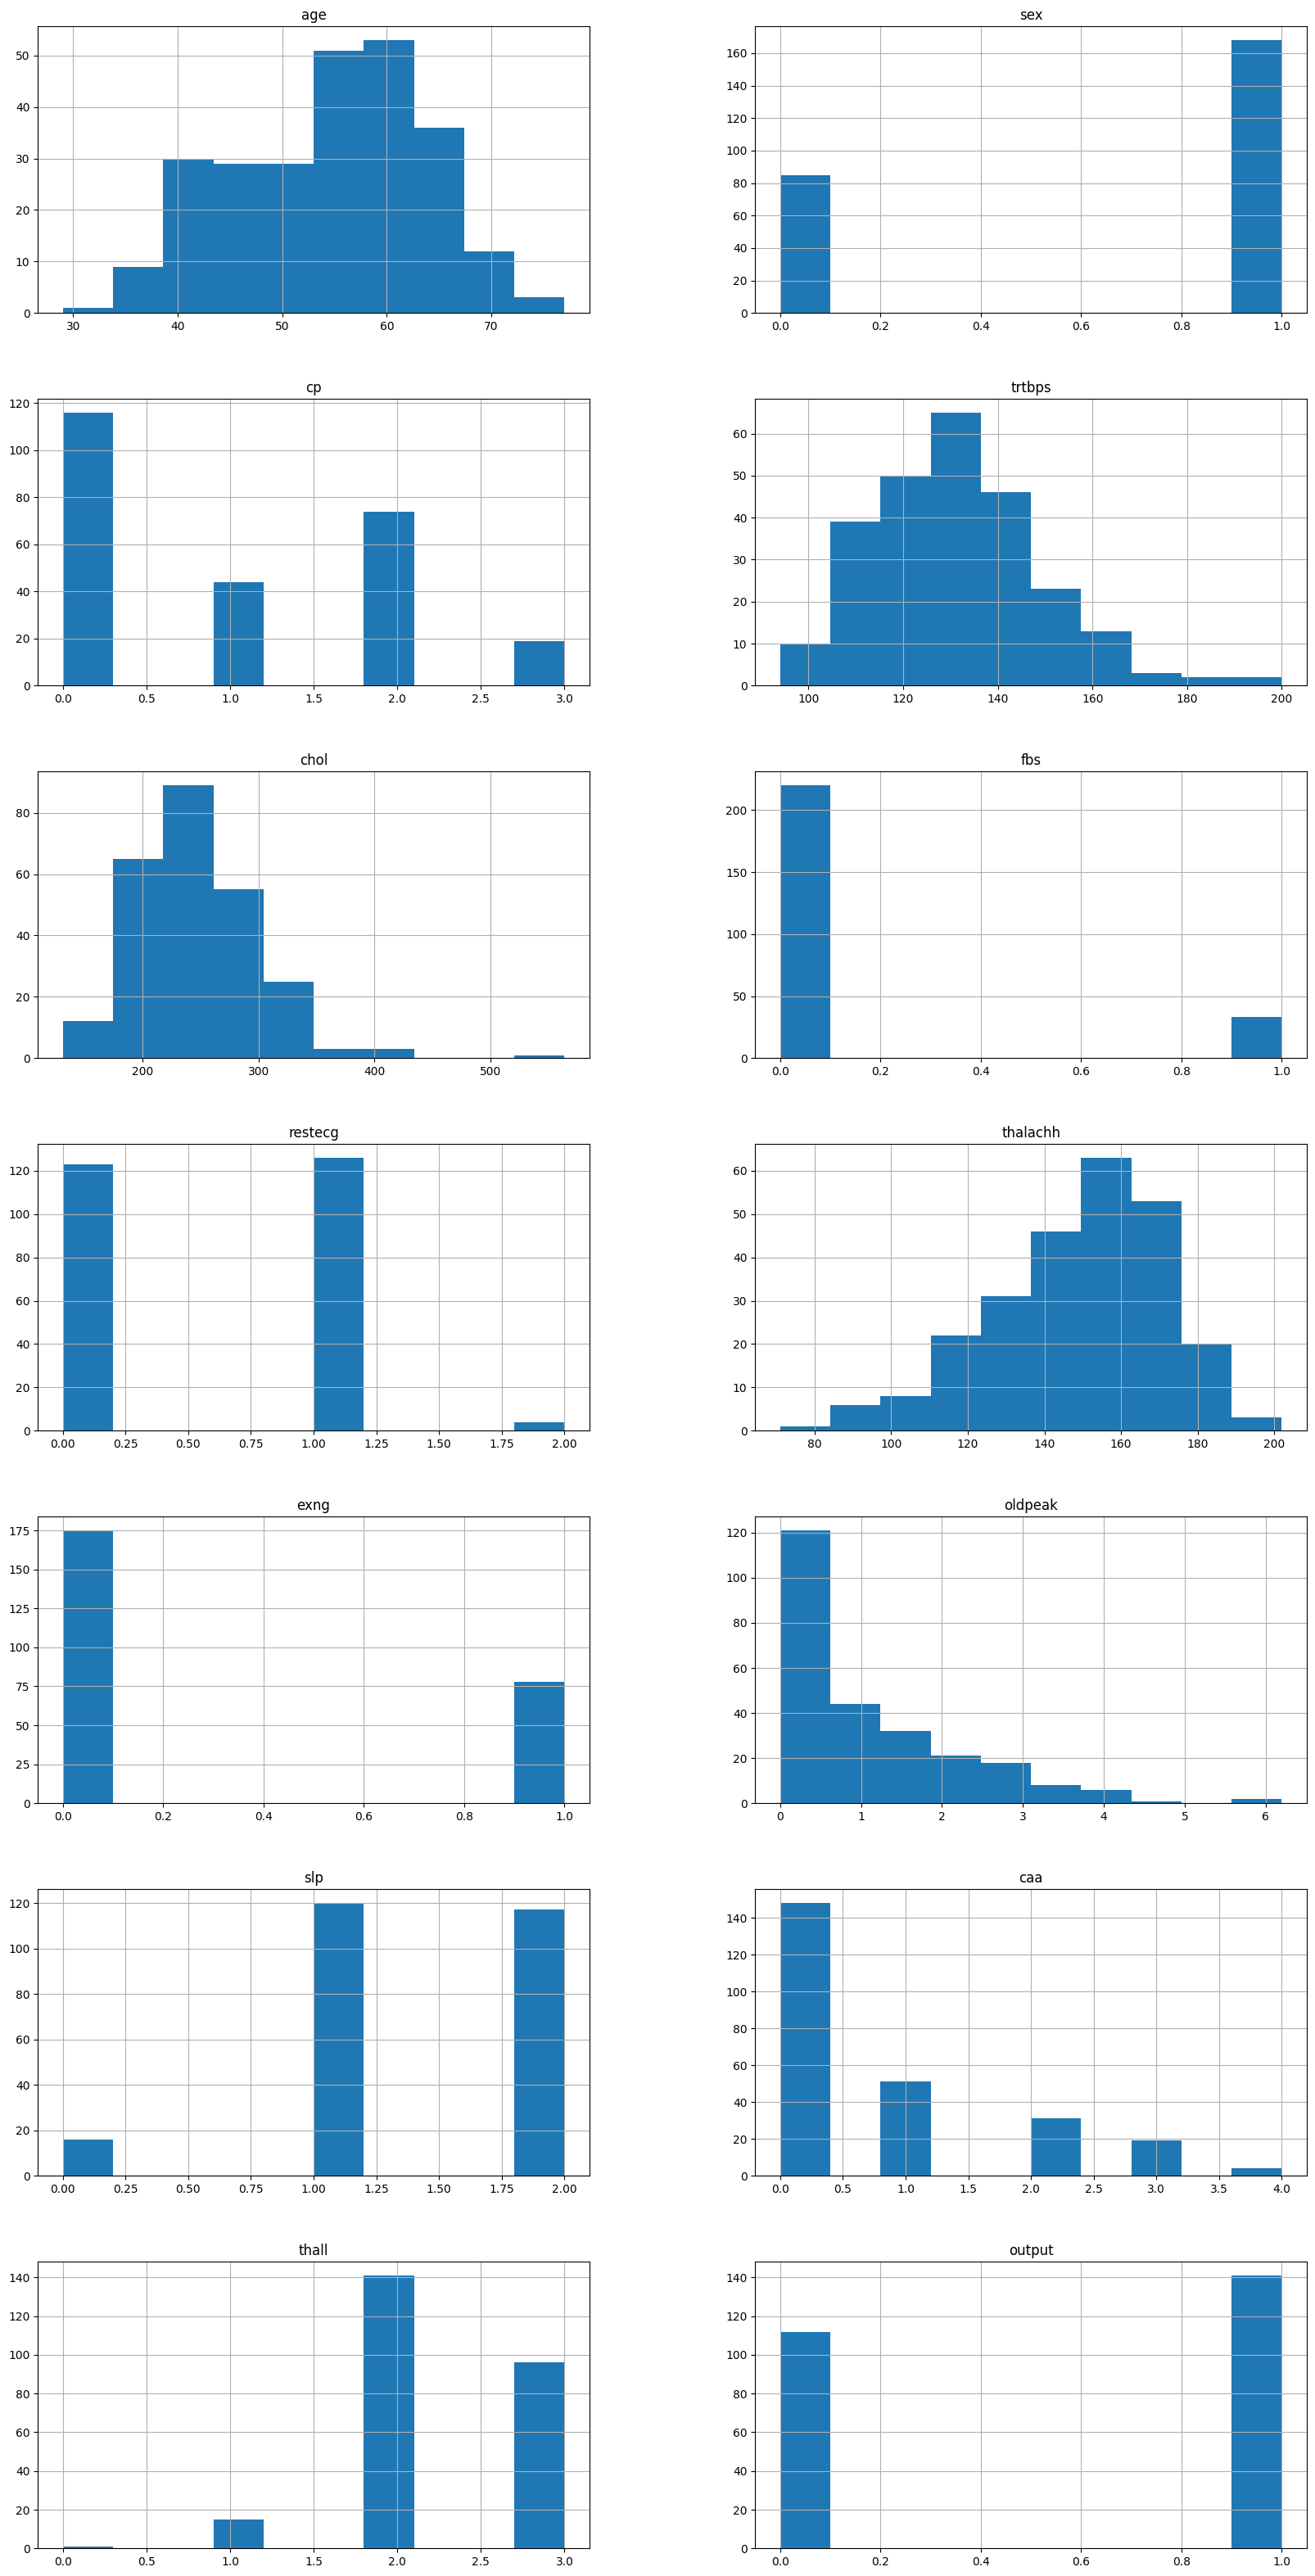

In [7]:
fig, axis = plt.subplots(7,2, figsize = (20,40))
df.hist(ax=axis);

- some discrete some continuous
- output is balanced

In [8]:
df.corr().output.sort_values()

oldpeak    -0.429223
caa        -0.418530
exng       -0.404441
thall      -0.373257
sex        -0.330692
age        -0.180887
trtbps     -0.141618
chol       -0.032140
fbs         0.038011
restecg     0.124957
slp         0.338046
thalachh    0.404585
cp          0.413145
output      1.000000
Name: output, dtype: float64

- some medium, some weak correlations
- no super strong

## Modeling

**Evaluation Framework**

In [9]:
def eval_lr(model,X,Y,n):
    
    TP_rates = []
    FN_rates = []
    
    # run evaluation n times
    for i in range(n):
    
        # Create train and test splits
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33)
        
        # fit model
        model.fit(X_train, Y_train)
        
        # calculate predictions
        y_pred = model.predict(X_test)
        
        # calculate confusion matrix
        matrix = confusion_matrix(y_pred, Y_test, labels = [1.0,0.0]) # y order and supplying labels is important
        
        # identify TP....etc
        TP = matrix[0][0]
        FP = matrix[1][0]
        FN = matrix[0][1]
        TN = matrix[1][1]
        
        # calculate important metrics
        # How many of predicted high riskers are actually high riskers? recall
        # How many of predicted low riskers are actually high riskers? False negative rate
        FN_rate = FP / (FP + TN)
        TP_rate = TP / (TP + FN) # recall
        
        # print iteration results
        # print(i, "TP_rate: ", TP_rate)
        # print(i, "FN_rate: ", FN_rate)
    
        # save iteration results
        TP_rates.append(TP_rate)
        FN_rates.append(FN_rate)
    
    # calculate average results and std_dev
    TP_rate_avg = sum(TP_rates) / len(TP_rates)
    FN_rate_avg = sum(FN_rates) / len(FN_rates)
    
    TP_rate_std = np.std(TP_rates)
    FN_rate_std = np.std(FN_rates)
    
    # show results
    print("average TP rate: ", TP_rate_avg, " -- TP rate std: ", TP_rate_std)
    print("average FN rate: ", FN_rate_avg, " -- FN rate std: ", FN_rate_std)
    
    plt.plot(TP_rates, color = "green")
    plt.plot(FN_rates, color = "red")
    plt.show()

    return TP_rates, FN_rates

**Baseline Model**

average TP rate:  0.8308683755630811  -- TP rate std:  0.03208028337458258
average FN rate:  0.1677229904986794  -- FN rate std:  0.05368306653615422


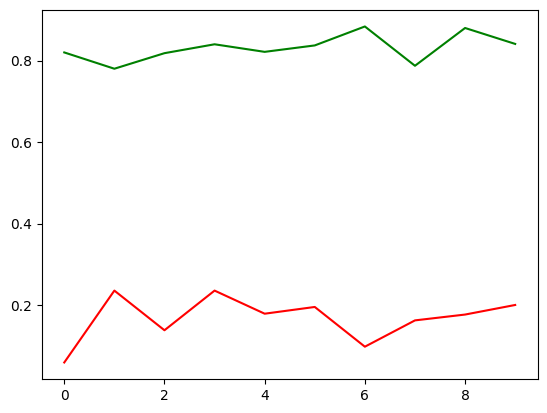

In [10]:
# define model
model = LogisticRegression(max_iter = 1000)

tpr, fnr = eval_lr(model,X,Y,10)

## Data Preprocessing

**Missing Values**
-  dont exist

**Outliers**
- remove some outliers with IQR

In [13]:
# create df for first preprocessing step()
drop = []

# loop through specific columns in df
for col in [3, 4, 7, 9]:

    # calc IQR
    q25, q75 = np.percentile(df.iloc[:,col], 25), np.percentile(df.iloc[:,col], 75)
    iqr = q75 - q25

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # identify outliers
    for i in range(len(df)):

        if df.iloc[i,col] < lower or df.iloc[i,col] > upper:
        
            drop.append(i)

df1 = df.drop(drop)

/Users/marklakshman/Coding_Projects/Math for DS testing/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


average TP rate:  0.8042922904381342  -- TP rate std:  0.049974523361038366
average FN rate:  0.12348281073281073  -- FN rate std:  0.055888521941114024


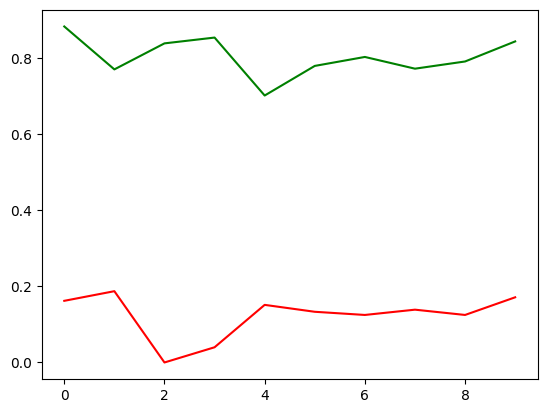

In [17]:
# test model after outlier removal
X1 = df1.values[:,:-1]
Y1 = df1.values[:,-1]
model1 = LogisticRegression(max_iter = 1000)

tpr, fnr = eval_lr(model1,X1,Y1,10)

- fnr got slightly better, but not impactfully enough
- rest got worse
- so model did not improve I would say

**ways to improve model**
1. scale data
2. remove variables
3. tune model